# Iris MLP

Back 2 basix.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from physics_mi.eval import plot_loss
from torch import nn
from tqdm.notebook import tqdm

In [3]:
class config:
    EPOCHS = 100
    LR = 1e-1

## Data

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset from sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_test, dtype=torch.int64)

In [5]:
X_train.shape, y_train.shape

(torch.Size([120, 4]), torch.Size([120]))

## Model

In [6]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # cba messing with the dataset that's already neatly packaged
        return self.layers(x)

## Training

In [7]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

model = model = Net(input_dim=4, hidden_dim=64, output_dim=y_train.unique().shape[0])
optimiser = Adam(model.parameters(), lr=config.LR, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
total_steps = len(X_train) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=config.LR, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    y_hat = model(X_train)
    loss = loss_func(y_hat, y_train)
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        y_hat = model(X_valid)
        valid_loss = loss_func(y_hat, y_valid)

    log_sample["valid_loss"] = float(valid_loss)
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/100 [00:00<?, ?it/s]

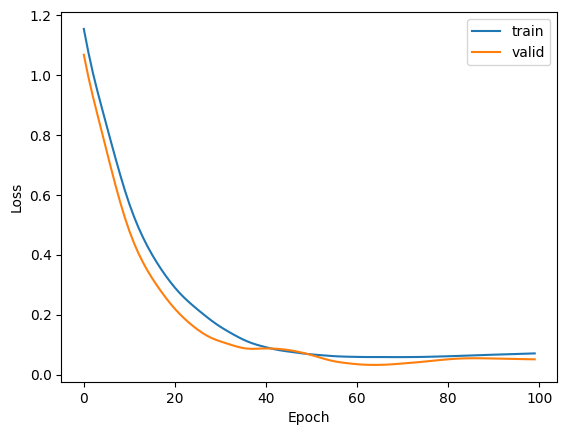

In [8]:
plot_loss(log["train_loss"], log["valid_loss"])

## Results

In [9]:
def get_preds(model, X_valid, y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = y_valid.numpy()

    return y_preds, y_targs

In [10]:
y_preds, y_targs = get_preds(model, X_valid, y_valid)
y_preds = y_preds.argmax(axis=1)

In [11]:
(y_preds == y_targs).mean()

1.0

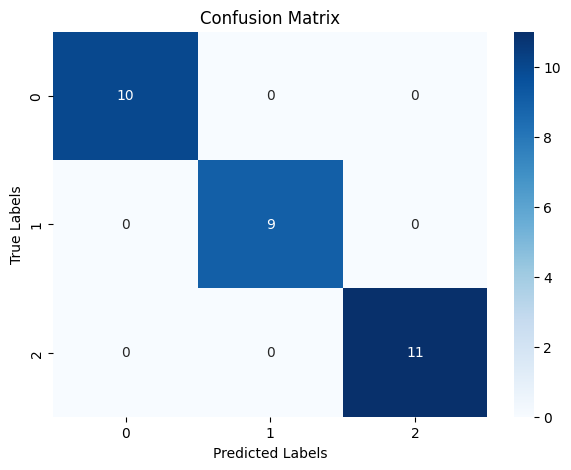

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_targs, y_preds)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Task independence

I'm keen to produce some plots like I did in `007-comp-graph/005-soft-mixing`.

In [13]:
from physics_mi.analysis import capture_intermediate_outputs
from physics_mi.graph import generate_graph
from physics_mi.analysis import plot_similarity_matrix, get_sims

In [14]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid

In [15]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet(input_dim=4, hidden_dim=64, output_dim=y_train.unique().shape[0])
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [16]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [ ]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)

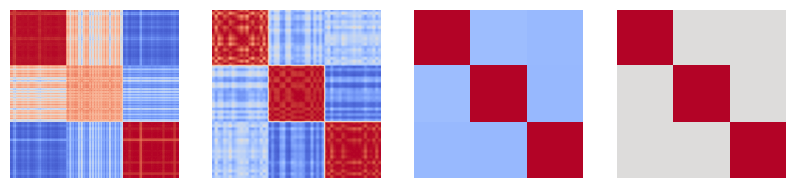

In [18]:
fig, axes = plt.subplots(1, len(layer_keys), figsize=(10, 10))

for ax, key in zip(axes, layer_keys):
    sims = get_sims(ndf, key)
    plot_similarity_matrix(sims, ax=ax, axis=False, colorbar=False)

This is cool, you can start to pick out some structure:
- There is task mixing throughout
- The 1st and 3rd output classes have components (in the input space and throughout) that strongly positively influence their own class prediction and they use the features of the other class to negatively influence their prediction. 
- This to me is saying for example with the 3rd class: ok, I have some features that I _know_ are really indicative of my class being present and I also know there are some features of the 1st class that are strongly indicative of that class being present and therefore mine _not_ being present (as we're doing single class prediction).
- The 2nd class has a more complex relationship with the other classes features (i.e. there is more interference), at least at the earlier layers.
- This to me is saying: there are features from class 1 that are useful in predicting my output and there are features from class 3 that either I don't care about (maybe they're not statistically useful in making my prediction), or that I can use as described before to negatively influence my prediction.
- It takes a couple of layers for these to be disambiguated with class 1's components.
- By the time we reach the penultimate set of components, each class is using activation in all the other class features to push down their own predictions. I suppose this is the kind of behaviour we expect from classification networks (as opposed to the regressors that I have been studying up until now).